# Transitland Datastore Issue [#352](https://github.com/transitland/transitland-datastore/issues/352):

Many `Station`/`StationPlatform`/`StationEntrance` and `Route` models in Transitland are also in OpenStreetMap. We currently conflate `Stop`s (soon to be `StationEntrance`s #256) with the nearest pedestrian way in OSM (using Valhalla). But we don't yet have any way to match a station polygon in OSM to the same station in Transitland, or to connect route geometries. This would be useful for analysis applications, as well as to remove duplicates when building vector tiles using both OSM and Transitland data (#351).

One potential approach:
1. Put a Onestop ID on feature(s) in OSM. For example: http://www.openstreetmap.org/way/77411120
2. In the Datastore, regularly use [Overpass API](https://github.com/BrunoSalerno/overpass-api-ruby) to query for features that have Onestop ID tags. Store (and regularly update) those OSM feature IDs in Transitland `Station` and `Route` models.

To do that at scale might require an editing UI or an addition to the iD OSM editor.

# References

http://wiki.openstreetmap.org/wiki/Public_transport

http://wiki.openstreetmap.org/wiki/Proposed_features/Public_Transport

http://wiki.openstreetmap.org/wiki/Railway_stations

https://overpass-turbo.eu/#

https://transit.land/api/v1/stops/s-9q8vzhbf8h-millbrae

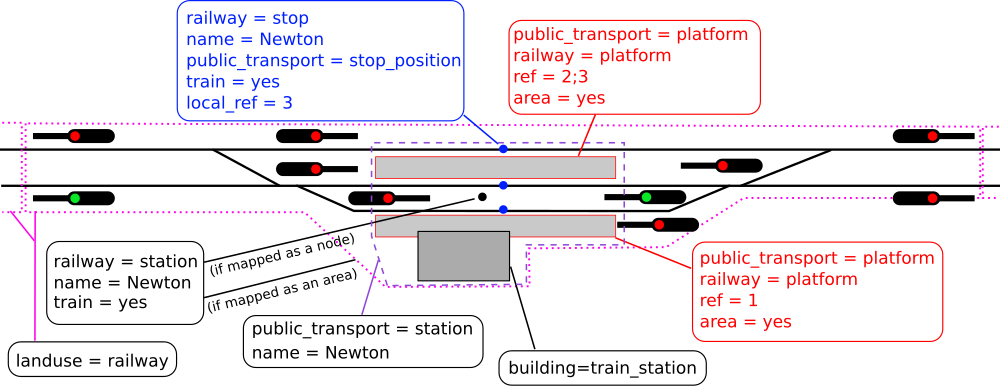

In [1]:
from IPython.display import Image
Image("http://wiki.openstreetmap.org/w/images/thumb/8/83/A-simple-station.svg/1000px-A-simple-station.svg.png")

# Which OpenStreetMap Tags to Use?

### Station tags:

- way["railway"="station"];
- way["public_transport"="station"];
- way["building"="train_station"];
- way["landuse"="railway"];
      
- node["railway"="station"]["usage" != "tourism"];
- node["public_transport"="station"];
- node["building"="train_station"]["train"="yes"]; 


Maybes:

- relation["public_transport"="stop_area"]

### Egress tags:

- node["railway" = "subway_entrance"]
- way["railway" = "subway_entrance"]

### Platform tags:

- way["railway" = "platform"]
- way["public_transport" = "platform"]

- node["railway" = "platform"]
- node["public_transport" = "platform"]

### Bus stop tags:

- way["highway" = "bus_stop"]
- node["highway" = "bus_stop"]

# Helper functions

Convert Overpass API JSON response to GeoJSON.

In [2]:
from geojson import FeatureCollection, Feature, Polygon, Point

def overpass2geojson(data):
    
    ways = [i for i in data['elements'] if i['type'] == 'way']
    nodes = [i for i in data['elements'] if i['type'] == 'node']
    pois = [i for i in nodes if 'tags' in i.keys()]
    
    print len(ways), "ways"
    print len(nodes), "total nodes"
    print len(pois), "POI nodes"
    
    # Create reference dicts for lookups by way_id and node_id
    lookup_wayid = {}
    lookup_nodeid = {}
    lookup_pois_nodeid = {} # POIs are nodes with tags
        
    # Populate reference dicts with info
    for i in nodes:
        lookup_nodeid[i['id']] = [i['lon'], i['lat']]
    
    for i in pois:
        lookup_pois_nodeid[i['id']] = i
        lookup_pois_nodeid[i['id']]["coordinates"] = lookup_nodeid[i['id']]
        
    for i in ways:
        lookup_wayid[i['id']] = i
        lookup_wayid[i['id']]["coordinates"] = [[lookup_nodeid[j] for j in i['nodes']]]
        lookup_wayid[i["id"]]["properties"] = lookup_wayid[i["id"]]["tags"]
        lookup_wayid[i["id"]]["properties"]["id"] = i["id"]
        lookup_wayid[i["id"]]["properties"]["type"] = "way"
        lookup_wayid[i["id"]]["properties"]["@id"] = "way" + "/" + str(i["id"])
    
    features = []
    # Append ways to features
    for i in lookup_wayid.keys():
        polygon = Polygon(lookup_wayid[i]['coordinates'])
        props = lookup_wayid[i]['properties']
        feature = Feature(geometry=polygon, properties=props)
        features.append(feature)
        
    # Append POI nodes to features
    for i in lookup_pois_nodeid.keys():
        point = Point(lookup_pois_nodeid[i]['coordinates'])
        props = lookup_pois_nodeid[i]['tags']
        feature = Feature(geometry=point, properties=props)
        features.append(feature)
        
    featureCollection = FeatureCollection(features)
    
    return featureCollection

Map GeoJSON with Leaflet (via Folium).

In [11]:
import folium

def overpass2leaflet(overpass_json, zoom_start=11, tiles="OpenStreetMap"):
    
    overpass_geojson = overpass2geojson(overpass_json)
    
    try:
        centerLat = overpass_json['elements'][0]['lat']
        centerLon = overpass_json['elements'][0]['lon']
    except:
        centerLat = overpass_json['elements'][-1]['lat']
        centerLon = overpass_json['elements'][-1]['lon']
    
    m = folium.Map(location=[centerLat, centerLon], zoom_start=zoom_start, tiles=tiles)        
    gj = folium.GeoJson(overpass_geojson)
    gj.add_to(m)

    return m

# 1) Get all stations within bbox

In [6]:
import requests
import urllib

In [7]:
def get_stations_in_bbox(bbox):
    """Returns station ways and nodes within bounding box"""
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="station"]{0};
      way["public_transport"="station"]{0};
      way["building"="train_station"]{0};
      way["landuse"="railway"]{0};
      
      node["railway"="station"]["usage" != "tourism"]{0};
      node["public_transport"="station"]{0};
      node["building"="train_station"]["train"="yes"]{0}; 
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [12]:
stations_in_bbox = get_stations_in_bbox("(37.66507, -122.598983, 37.861302, -122.211227)")

In [13]:
overpass2leaflet(stations_in_bbox)

22 ways
434 total nodes
20 POI nodes


# 2) Get all stations near OSM way id

In [14]:
def get_stations_near_way_id(osm_way_id, radius=50):
    '''Returns station ways and nodes with radius to a specified OSM way id'''
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    way(id:{0})->.target;

    (
      // Get ways near way target
      way(around.target:{1})["railway"="station"];
      way(around.target:{1})["public_transport"="train_station"];
      way(around.target:{1})["building"="train_station"];
      way(around.target:{1})["landuse"="railway"];
      
      // Get nodes near node target
      node(around.target:{1})["railway"="station"]["usage" != "tourism"];
      node(around.target:{1})["public_transport"="train_station"];
      node(around.target:{1})["building"="train_station"];
    );

    out body;
    >;
    out skel qt;
    """.format(osm_way_id, radius)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [15]:
stations_near_way_id = get_stations_near_way_id(286685354)

In [16]:
overpass2leaflet(stations_near_way_id, zoom_start=17)

1 ways
41 total nodes
1 POI nodes


# 3) Get all stations near lat/lon

In [17]:
def get_stations_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      // Get ways
      way(around:{0}, {1}, {2})["railway"="station"];
      way(around:{0}, {1}, {2})["public_transport"="train_station"];
      way(around:{0}, {1}, {2})["building"="train_station"];
      way(around.target:{1})["landuse"="railway"];
      
      // Get nodes
      node(around:{0}, {1}, {2})["railway"="station"]["usage" != "tourism"];
      node(around:{0}, {1}, {2})["public_transport"="train_station"];
      node(around:{0}, {1}, {2})["building"="train_station"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [18]:
stations_near_latlon = get_stations_near_latlon(lat=37.600271, lon=-122.386702)

In [19]:
overpass2leaflet(stations_near_latlon, zoom_start=17)

1 ways
41 total nodes
1 POI nodes


# 4) Get all subway entrances in bbox

In [20]:
def get_subway_entrances_in_bbox(bbox):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="subway_entrance"]{0};
      node["railway"="subway_entrance"]{0};
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [21]:
subway_entrances_in_bbox = get_subway_entrances_in_bbox("(37.66507, -122.598983, 37.861302, -122.211227)")

In [22]:
overpass2leaflet(subway_entrances_in_bbox)

1 ways
85 total nodes
81 POI nodes


# 5) Get all subway entrances near OSM way id

In [23]:
def get_subway_entrances_near_way_id(osm_way_id, radius=50):
    '''Returns station ways and nodes with radius to a specified OSM way id'''
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    way(id:{0})->.target;

    (
      way(around.target:{1})["railway"="station"];
      node(around.target:{1})["railway"="station"]["usage" != "tourism"];
    );

    out body;
    >;
    out skel qt;
    """.format(osm_way_id, radius)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [24]:
subway_entrances_near_way_id = get_subway_entrances_near_way_id(286685354)

In [25]:
overpass2leaflet(subway_entrances_near_way_id, zoom_start=17)

0 ways
1 total nodes
1 POI nodes


# 6) Get all subway entrances near lat/lon

In [26]:
def get_subway_entrances_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way(around:{0}, {1}, {2})["railway"="subway_entrance"];
      node(around:{0}, {1}, {2})["railway"="subway_entrance"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [27]:
subway_entrances_near_latlon = get_subway_entrances_near_latlon(lat=37.789403, lon=-122.401080)

In [28]:
overpass2leaflet(subway_entrances_near_latlon, zoom_start=18)

0 ways
2 total nodes
2 POI nodes


# 7) Get all platforms within bbox

In [29]:
def get_platforms_in_bbox(bbox):
    """Returns station ways and nodes within bounding box"""
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="platform"]{0};
      way["public_transport"="platform"]{0};
      
      node["railway"="platform"]{0};
      node["public_transport"="platform"]{0};
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [30]:
platforms_in_bbox = get_platforms_in_bbox("(37.66507, -122.598983, 37.861302, -122.211227)")
overpass2leaflet(platforms_in_bbox)

133 ways
452 total nodes
63 POI nodes


# 8) Get all platforms near OSM way id

In [31]:
def get_platforms_near_way_id(osm_way_id, radius=50):
    '''Returns station ways and nodes with radius to a specified OSM way id'''
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    way(id:{0})->.target;

    (
      // Get ways near way target
      way(around.target:{1})["railway"="platform"];
      way(around.target:{1})["public_transport"="platform"];
      
      // Get nodes near node target
      node(around.target:{1})["railway"="platform"];
      node(around.target:{1})["public_transport"="platform"];
    );

    out body;
    >;
    out skel qt;
    """.format(osm_way_id, radius)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [32]:
platforms_near_way_id = get_platforms_near_way_id(286685354)

overpass2leaflet(platforms_near_way_id, zoom_start=18)

4 ways
21 total nodes
0 POI nodes


# 9) Get all platforms near lat/lon

In [33]:
def get_platforms_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way(around:{0}, {1}, {2})["railway"="platform"];
      way(around:{0}, {1}, {2})["public_transport"="platform"];
      node(around:{0}, {1}, {2})["railway"="platform"];
      node(around:{0}, {1}, {2})["public_transport"="platform"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    
    return data

In [34]:
platforms_near_latlon = get_platforms_near_latlon(lat=37.600271, lon=-122.386702)

overpass2leaflet(platforms_near_latlon, zoom_start=18)

5 ways
24 total nodes
0 POI nodes


# Random notes...

Here's a custom overpass -> geojson function without the dependency on external geojson library:

In [35]:
def overpass2geojson_standalone(data):
    ways = [i for i in data["elements"] if i["type"] == "way"]
    nodes = [i for i in data["elements"] if i["type"] == "node"]
    
    # Create reference dicts for quick lookups
    lookup_wayid = {}
    lookup_nodeid = {}
        
    for i in nodes:
        lookup_nodeid[i["id"]] = [i["lon"], i["lat"]]
        
    for i in ways:
        lookup_wayid[i["id"]] = i
        
        lookup_wayid[i["id"]]["geometry"] = {
            "coordinates": [[lookup_nodeid[j] for j in i["nodes"]]],
            "type": "Polygon"
        }
        lookup_wayid[i["id"]]["properties"] = lookup_wayid[i["id"]]["tags"]
        
    # Write geojson
    geojson_output = {
      "type": "FeatureCollection",
      "generator": "overpass-ide",
      "copyright": "The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.",
      "features": []
    }
    
    for i in lookup_wayid.keys():
        geo_feature = {
          "type": "Feature",
          "properties": lookup_wayid[i]["tags"],
          "geometry": lookup_wayid[i]["geometry"],
          "id": i        
        }
        geojson_output["features"].append(geo_feature)
        
    return geojson_output

In [ ]:
m = folium.Map(location=[37.8, -122.3], zoom_start=12)
folium.GeoJson(geojson).add_to(m)
m